In [1]:
# import packages
import math
import random
import matplotlib
import numpy as np
import sympy as sp 
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.vector import init_vprinting
import plotly.express as px
import plotly.graph_objects as go

# configure pretty latex like printing
init_vprinting(use_latex='mathjax', pretty_print=False)

# global variables
# link lengths (in centimeters)
L1_LENGTH = 100
L2_LENGTH = 100
# grid variables
NUMBER_ROWS = 20
NUMBER_COLS = 20

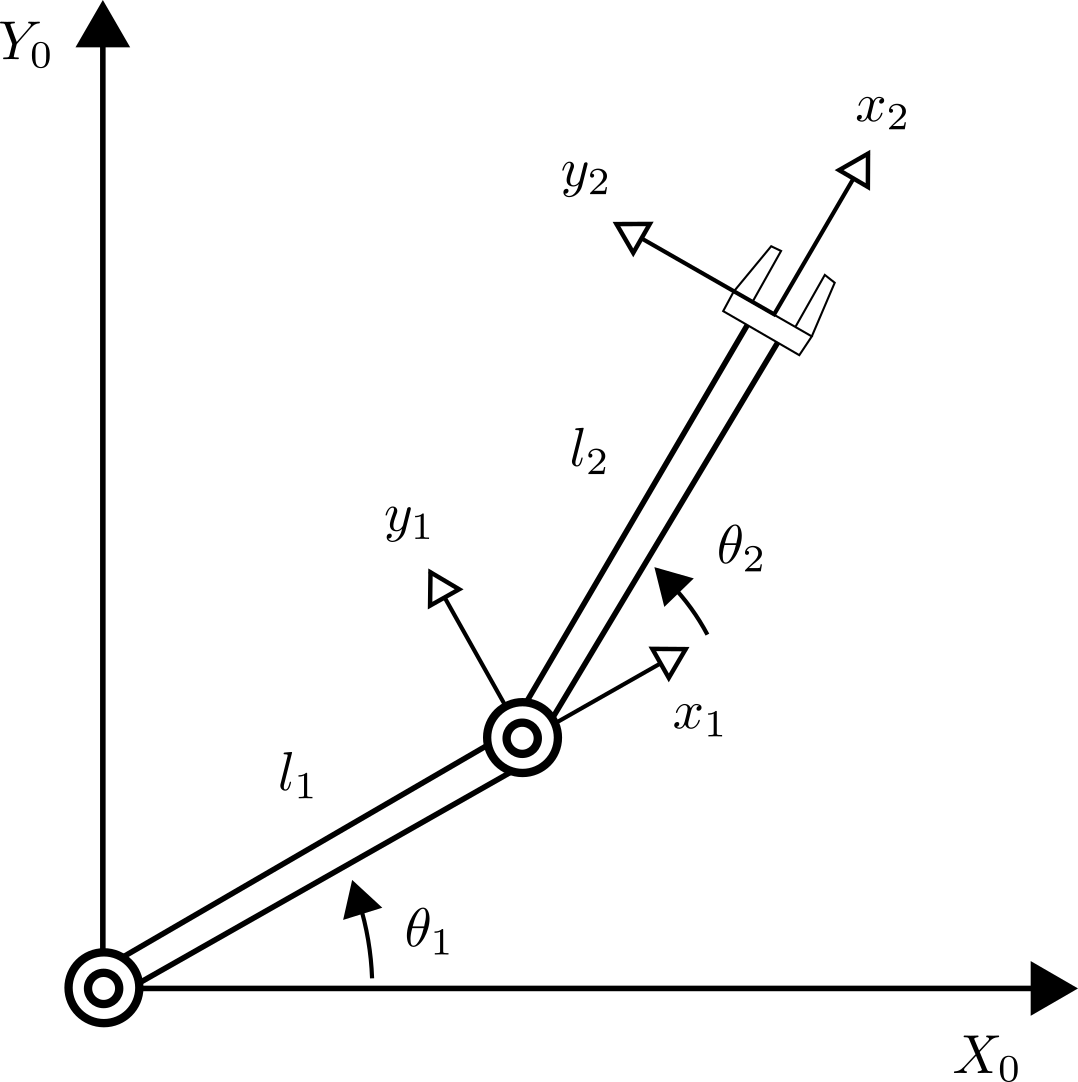

In [2]:
# here's an image of the robot arm in question
# it's a two link planar manipulator (2PR) 
from IPython.display import Image
Image('fig/img1.png', width=300)

In [3]:
# declare the symbolic variables
# we'll need to do linear algebra
theta1, theta2, l1, l2, theta, alpha, a, d = \
    dynamicsymbols('theta1 theta2 l1 l2 theta alpha a d')
# show the symbolic variables we've made
theta1, theta2, l1, l2, theta, alpha, a, d

(theta1, theta2, l1, l2, theta, alpha, a, d)

In [4]:
# rotation matrix based off
# of our dh table
rotation_matrix = sp.Matrix(
    [
        [
            sp.cos(theta), 
            -sp.sin(theta) * sp.cos(alpha),
            sp.sin(theta) * sp.sin(alpha)
        ], [
            sp.sin(theta),
            sp.cos(theta) * sp.cos(alpha), 
            -sp.cos(theta) * sp.sin(alpha)
        ], [
            0, 
            sp.sin(alpha), 
            sp.cos(alpha)
        ]
    ]
)
# x,y,z transformation matrix
transformation_matrix = \
    sp.Matrix([a * sp.cos(theta), a * sp.sin(theta), d])
# the definition for the last row
# in a homogenous transformation matrix
last_row = sp.Matrix([[0, 0, 0, 1]])
# combine the rotation, transformation and last row
# to get homogenous transformation matrix
t = sp.Matrix.vstack(
    sp.Matrix.hstack(rotation_matrix, transformation_matrix), 
    last_row
)
# show the homogenous transformation matrix
display(t)

Matrix([
[cos(theta), -sin(theta)*cos(alpha),  sin(alpha)*sin(theta), a*cos(theta)],
[sin(theta),  cos(alpha)*cos(theta), -sin(alpha)*cos(theta), a*sin(theta)],
[         0,             sin(alpha),             cos(alpha),            d],
[         0,                      0,                      0,            1]])

In [5]:
# given the homogenous transformation matrix
# we need to find the transformation from 
# frame 0 to frame 2
t_02 = (
    t.subs({alpha:0, a:l1, theta:theta1, d:0}) * 
    t.subs({alpha:0, a:l2, theta:theta2, d:0})
)

# simplify t_02 using
# sympy methods
t_02 = sp.Matrix(
    [[
        t_02[0, 0].simplify(), t_02[0, 1].simplify(),
        sp.trigsimp(t_02[0, 3].simplify())
    ], [
        t_02[1, 0].simplify(), t_02[1, 1].simplify(),
        sp.trigsimp(t_02[1, 3].simplify())
    ], [
        t_02[2, 0].simplify(), t_02[2, 1].simplify(), 
        t_02[2, 2].simplify()
    ]]
)

# show the transformation_matrix
# for 0 to 2
display(t_02)

Matrix([
[cos(theta1 + theta2), -sin(theta1 + theta2), l1*cos(theta1) + l2*cos(theta1 + theta2)],
[sin(theta1 + theta2),  cos(theta1 + theta2), l1*sin(theta1) + l2*sin(theta1 + theta2)],
[                   0,                     0,                                        1]])

In [6]:
# give our transformation matrix
# we can derive forward kinematics
# for example
x_position = t_02[0,2]
y_position = t_02[1,2]
# show the functions for
# x and y positions
display(x_position)
display(y_position)

l1*cos(theta1) + l2*cos(theta1 + theta2)

l1*sin(theta1) + l2*sin(theta1 + theta2)

In [7]:
# using sympy's lambdify function 
# we can turn the forward kinematic
# equations into standard functions
fx = sp.lambdify((l1, l2, theta1, theta2), x_position, 'numpy')
fy = sp.lambdify((l1, l2, theta1, theta2), y_position, 'numpy')

In [8]:
# now we can choose random inputs
# fuzz the output position
# first generate random angle inputs
# for theta1 and theta2
inputs = [
    (
        np.deg2rad(random.uniform(0,170)),
        np.deg2rad(random.uniform(-90,90))
    ) for x in range(5000)
]

# map the forward kinematics 
# equations onto the input set
outputs = [
    {
        "angles": (i[0], i[1]),
        "fk": (
            fx(L1_LENGTH, L2_LENGTH, i[0], i[1]),
            fy(L1_LENGTH, L2_LENGTH, i[0], i[1]) 
        )
    } for i in inputs
]

In [9]:
x_cord = list(map(lambda e: e['fk'][0], outputs))
y_cord = list(map(lambda e: e['fk'][1], outputs))
fig = px.scatter(x=x_cord, y=y_cord)
fig.show()

# what are the minimums and maximums 
# for the output dimensions
# so we can develop a grid
x_min = math.floor(min(x_cord))
y_min = math.floor(min(y_cord))
x_max = math.ceil(max(x_cord))
y_max = math.ceil(max(y_cord))
print("x_min :", x_min, " x_max: ", x_max)
print("y_min :", y_min, " y_max: ", y_max)

x_min : -199  x_max:  200
y_min : -100  y_max:  200


In [10]:
# first set up a grid of points
# so we can determine how to group
# results from forward kinematics
cell_width = abs(x_max-x_min) / NUMBER_COLS
cell_height = abs(y_max - y_min) / NUMBER_COLS
grid_points = [
    [
        [(x,y)] for x in np.arange(x_min, x_max, cell_width)
    ] for y in np.arange(y_min, y_max, cell_height)
]

# for each generated forward kinematics
# output coordinate, we need to find it's
# position in the grid and put in the grid
# array we made previously
for output in outputs:    
    xx = math.floor(
        (
            (abs(NUMBER_COLS * (output['fk'][0] - x_min)) / (x_max-x_min))
        ) 
    )
    yy = math.floor(
        (
            (abs(NUMBER_ROWS * (output['fk'][1] - y_min)) / (y_max-y_min))
        ) 
    )
    grid_points[xx][yy] += {(output['fk'][0], output['fk'][1])}

In [15]:
# some helper objects for the chart
# we're about to make, dictionary of
# colors we can randomly select from
hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []

for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)

# now plot each grid as an individual
# trace in the scatter plot
grid_plot = go.Figure()
for row in grid_points:
    for col in row:
        if(len(col) == 0): continue
        
        x=list(map(lambda x: x[0], col))
        y=list(map(lambda y: y[1], col))
        
        grid_plot.add_trace(
            go.Scatter(
                x=x, 
                y=y,
                fillcolor=random.choice(hex_colors_only),
                name=str(name)
            )
        )
# show the plot
grid_plot.show()